# Author: Yoonhyuck WOO / JBNU_Industrial Information system Engineering
# Date; 3. 7. 2022 - 3. 17. 2022
# Title: Korean_NER
# Professor: Seung-Hoon Na

In [2]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'

print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 38.4 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import os
import json
import numpy as np
from functools import partial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, FlaubertModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# BertTokenizer
 - return tensors = "pt" : Finally, you want the tokenizer to return the actual tensors that are fed to the model.
 
# BertModel
 - Attention_mask : 1 where you care and 0 where you don't care.
 - Input_ids : the IDs of the sentence morpheme.
 - Token_type_ids : for the question problem, but it's enough to set it to zero now.

reference: https://huggingface.co/docs/transformers/model_doc/bert

# Example

In [6]:
PRETAINED_MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(PRETAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

# Loading Data

In [7]:
PATH_dir = '/content/drive/My Drive/Colab Notebooks/Ko_En_NER_POStag_data/Ko_NER_POS/'
PATH_ko_train = os.path.join(PATH_dir, 'prepro_train.json')
PATH_ko_test = os.path.join(PATH_dir, 'prepro_test.json')
PATH_ko_dev = os.path.join(PATH_dir, 'prepro_dev.json')
total_tag = os.path.join(PATH_dir, 'total_tag.json')

In [8]:
with open(PATH_ko_dev) as data_file:
  dataset_dev = json.load(data_file)
with open(PATH_ko_test) as data_file:
  dataset_test = json.load(data_file)
with open(PATH_ko_train) as data_file:
  dataset_train = json.load(data_file) 

In [9]:
print('train', len(dataset_train))
print('test', len(dataset_test))
print('dev', len(dataset_dev))
# tag_converter.id_to_tag

train 4250
test 500
dev 250


# convert_Tag_to_id

In [10]:
def convert_Tag_to_id_list(batch):
  tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}
  total = []
  t_to_i = []
  for j in batch:
      j = tag_to_id.get(j)
      t_to_i.append(j)

  return t_to_i

# convert_id_to_tag

In [11]:
def convert_id_to_tag_list(batch):
  id_to_tag ={0: '[PAD]', 1: 'B-<휠', 2: 'B-OG', 3: 'I-조선', 4: 'I-PS', 5: 'B-LC', 6: 'B-1', 7: 'I-<휠', 8: 'I-LC', 9: 'B-PS', 
              10: 'I-TI', 11: 'B-목소', 12: 'O', 13: 'I-목소', 14: 'I-1', 15: 'I-', 16: 'B-조선', 17: 'I-OG', 18: 'B-', 19: 'I-DT', 20: 'B-TI', 21: 'B-DT'}
  total = []
  i_to_t = []
  for j in batch:
      j = id_to_tag.get(j)
      i_to_t.append(j)

  return i_to_t

In [12]:
convert_Tag_to_id_list(['O','I-목소'])

[12, 13]

In [13]:
convert_id_to_tag_list([12, 13])

['O', 'I-목소']

# Make Batch & Padding

In [14]:
def make_batch(labels, max_len):
  batch_labels = []
  special_token = 0

  for taglist in labels:
    sample = [special_token] + convert_Tag_to_id_list(taglist)[:max_len-2] + [special_token]
    sample +=[special_token] * max(0, max_len - (len(sample)))
    batch_labels.append(sample)
    # print(batch_labels)
    
  return torch.tensor(batch_labels)

In [15]:
tag = [['B-OG', 'I-OG', 'I-조선', 'I-OG', 'I-OG', 'I-DT'],  # 0, 2, 17, 3, 17, 17, 19, 0
       ['O', 'B-DT', 'I-DT', 'B-DT', 'I-DT', 'I-DT', 'I-DT', 'I-DT', 'B-LC','O', 'O', 'B-OG', 'I-OG', 'I-OG', 'I-OG'], 
       ['I-OG', 'O', 'O', 'O', 'B-PS', 'O', 'B-PS', 'I-PS', 'I-PS', 'O', 'B-LC', 'O', 'O', 'B-OG',], 
       ['B-PS', 'O', 'O', 'O', 'O', 'O', 'O', 'O','O', 'O', 'O', 'O', 'I-DT','I-PS', 'I-PS']]

In [16]:
make_batch(tag,17)

tensor([[ 0,  2, 17,  3, 17, 17, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 12, 21, 19, 21, 19, 19, 19, 19,  5, 12, 12,  2, 17, 17, 17,  0],
        [ 0, 17, 12, 12, 12,  9, 12,  9,  4,  4, 12,  5, 12, 12,  2,  0,  0],
        [ 0,  9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 19,  4,  4,  0]])

In [17]:
print(len(tag[0]), len(tag[1]) ,len(tag[2]) ,len(tag[3]))

6 15 14 15


In [18]:
def ner_fn_custom(tokenizer, make_batch, data):
    
    input_sent = [sample[0] for sample in data]
    labels = [sample[2] for sample in data]

    batch_inputs = tokenizer(input_sent, padding = True, return_tensors = "pt")
    batch_labels = make_batch(labels, max_len = batch_inputs['input_ids'].size(1))

    return batch_inputs, batch_labels

In [19]:
batch_size = 15
# partial (func, /, *args, **keywords)  positional argument: args, keyword argument: keywords

# partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
# partial_collate_fn = collate_fn_custom

partial_collate_fn = partial(ner_fn_custom, tokenizer, make_batch)
'''
partial_collate_fn = partial(collate_fn_custom, tokenizer, tag_converter)
'''
# ner_collate_fn: padding & making batch?
'''
def ner_collate_fn(tokenizer, tag_converter):
    
'''

'\ndef ner_collate_fn(tokenizer, tag_converter):\n    \n'

# DataLoader
- responsible for deployment management
- easier to repeat the arrangement.
- automatically provide individual mini-batch

reference: https://hulk89.github.io/pytorch/2019/09/30/pytorch_dataset/

In [20]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = partial_collate_fn)

dataloader_test = DataLoader(
    dataset_test,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

dataloader_dev = DataLoader(
    dataset_dev,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = partial_collate_fn)

#Bert_NER Model
 - Dropout: method to solve overfitting, one of the problems in deep learning learning. In summary, how to prevent some units of the hidden layer from being overfitted by inoperative<br>
    ->the outputs are scaled by a factor of (1 / 1-p)  during training

# *args, **kargs
 - *args(non-keworded arguments): Tuple type of argument without limitation.
 - **kargs(keworded arguments):  Dictionary type of argument without limitation.

# nn.Module
 - model.train() & model.eval(): A function that switches to perform other tasks performed at train time and eval time.

   - Typical examples of how to operate differently at train time and eval time are: Dropout Layer, BatchNorm Layer, etc

reference: https://bluehorn07.github.io/2021/02/27/model-eval-and-train.html

In [21]:
class Bert_NER(nn.Module):  
    def __init__(self, bert):
        super().__init__() 
        bert = BertModel.from_pretrained(PRETAINED_MODEL_NAME)     
        self.bert = bert
        self.dropout = nn.Dropout(p = 0.1)
        self.linear = nn.Linear(768, 22)
        self.softmax = nn.Softmax(dim = 2) # A dimension along which Softmax will be computed
    
    def forward(self, **kwargs):
        emb = self.bert(**kwargs)
        e = self.dropout(emb['last_hidden_state'])
        w = self.linear(e)
        
        return w

In [22]:
# tag_num = len(tag_to_id) # <=22 
'''tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
   'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}'''
model = Bert_NER(22)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
model.cuda()
device = model.bert.device

In [24]:
print(device)

cuda:0


# nn.CrossEntropyLoss
 :Integrated classes with LogSoftmax and NLLLoss == softmax -> log -> negative to positive and mean/sum

 # LogSoftmax
 : softmax makes probability distribution with a sum of 1, and the probability distribution was taken by log

# NLLLoss (Negative Log Likelihood Loss)
- Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network
- The expression is loss=-weight*input to change the negative to positive, and the sum or average value is obtained by sigma calculation and used as loss.
- negative log (-log)
   - the closer the predicted probability is to 1, the smaller the loss is
   - and the closer the predicted probability is to 0, the greater the loss is
   - Given that entropy is instability or uncertainty => learning in the form of strict regulation of incorrect answers and praise for good judgments close to correct answers in order to create a confident model.

reference: https://blog.naver.com/PostView.naver?blogId=vail131&logNo=222474864230&parentCategoryNo=&categoryNo=21&viewDate=&isShowPopularPosts=true&from=search

In [25]:
CELoss = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = AdamW(model.parameters(), lr = 1.0e-4)
draw = []

# Training

 29 - loss: 0.45679956674575806
 59 - loss: 0.20505128800868988
 89 - loss: 0.21201114356517792
119 - loss: 0.12866206467151642
149 - loss: 0.24327540397644043
179 - loss: 0.22246994078159332
209 - loss: 0.3505331575870514
239 - loss: 0.06464296579360962
269 - loss: 0.05894820764660835
epoch1: 완료

 29 - loss: 0.10738523304462433
 59 - loss: 0.15778027474880219
 89 - loss: 0.19576343894004822
119 - loss: 0.032272614538669586
149 - loss: 0.13503441214561462
179 - loss: 0.08809689432382584
209 - loss: 0.08296068757772446
239 - loss: 0.13268013298511505
269 - loss: 0.07749941200017929
epoch2: 완료



Text(0, 0.5, 'loss')

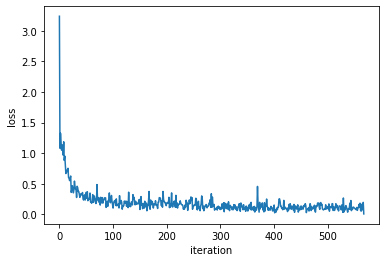

In [26]:
for epoch in range(2):
  model.train() # switching to training mode
  for iteration, batch in enumerate(dataloader_train):
      batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
      batch_labels = batch[1].cuda(device)

      output = model(**batch_inputs)
      loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      draw.append(loss.item())
      if (iteration + 1) % 30 == 0:
          print(f'{iteration:3} - loss: {loss.item()}')
  print("epoch{}: 완료\n".format(epoch + 1))
plt.plot(draw)
plt.xlabel("iteration")
plt.ylabel("loss")

# Test

loss: 2.300346851348877
loss: 2.396324396133423
loss: 1.671981930732727
loss: 1.850253939628601
loss: 1.8578155040740967
loss: 2.572699546813965
loss: 2.0468192100524902
loss: 2.4985549449920654
loss: 2.2966747283935547
loss: 2.6765758991241455
loss: 2.378995656967163
loss: 2.0500223636627197
loss: 2.5331814289093018
loss: 2.1755127906799316
loss: 2.0618093013763428
loss: 2.262402296066284
loss: 2.2216367721557617
loss: 2.0307533740997314
loss: 2.4322733879089355
loss: 1.3413193225860596
loss: 2.5131642818450928
loss: 3.089095115661621
loss: 2.460824489593506
loss: 2.1933584213256836
loss: 2.179764986038208
loss: 2.2558484077453613
loss: 2.3633923530578613
loss: 2.6919336318969727
loss: 2.3760907649993896
loss: 1.6470606327056885
loss: 1.9532285928726196
loss: 2.663623332977295
loss: 2.1563808917999268
loss: 3.0011425018310547


Text(0, 0.5, 'loss')

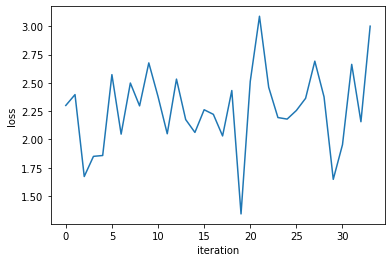

In [27]:
model.eval() # switching to evalutating mode: a function that turns off layers that should not be used in the evaluation process.

gold_list = [] # true
pred_list = []
draw_test = []

with torch.no_grad():
    for iteration, batch in enumerate(dataloader_test):
        batch_inputs = {k: v.cuda(device) for k, v in list(batch[0].items())}
        batch_labels = batch[1].cuda(device)

        output = model(**batch_inputs)

        loss = CELoss(output.view(-1, output.size(-1)), batch_labels.view(-1))

        print('loss:', loss.item())
        draw_test.append(loss.item())

        pred_ids = torch.argmax(output, dim = -1)
        
        # print(pred_ids)
        for g, p in zip(batch_labels, pred_ids):
            gold_mask = g != 0 #tag_converter.pad_id
            
            gold = convert_id_to_tag_list(g[gold_mask].tolist())
            pred = convert_id_to_tag_list(p[gold_mask].tolist())
            gold_list.append(gold)
            pred_list.append(pred)
            
            # print(gold)
            # print(pred)
plt.plot(draw_test)
plt.xlabel("iteration")
plt.ylabel("loss")

In [28]:
gold_list_flat = []
pred_list_flat = []
for g, p in zip(gold_list, pred_list):
    gold_list_flat += g
    pred_list_flat += p

In [33]:
  tag_to_id ={'PAD': 0, 'B-<휠': 1, 'B-OG': 2, 'I-조선': 3, 'I-PS': 4, 'B-LC': 5, 'B-1': 6, 'I-<휠': 7, 'I-LC': 8, 'B-PS': 9, 'I-TI': 10, 
              'B-목소': 11, 'O': 12, 'I-목소': 13, 'I-1': 14, 'I-': 15, 'B-조선': 16, 'I-OG': 17, 'B-': 18, 'I-DT': 19, 'B-TI': 20, 'B-DT': 21}

Precision:- Accuracy of positive predictions.

Precision = TP/(TP + FP)

 

Recall:- Fraction of positives that were correctly identified.

Recall = TP/(TP+FN)

 

F1 score

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

 

Accuracy : (TP+TN) / all

 

macro avg = (normal+abnormal) /2 * precision or recall or f1 score

weighted avg = normal/(normal+abnormal)  *  precision or recall or f1 score

reference: https://datainsider.tistory.com/53

In [38]:
print(classification_report(gold_list_flat, pred_list_flat, digits=5, labels=list(tag_to_id.keys())[1:]))

              precision    recall  f1-score   support

        B-<휠    0.00000   0.00000   0.00000         0
        B-OG    0.29953   0.25049   0.27282       507
        I-조선    0.00000   0.00000   0.00000         0
        I-PS    0.03271   0.17834   0.05528       157
        B-LC    0.25547   0.26515   0.26022       132
         B-1    0.00000   0.00000   0.00000         1
        I-<휠    0.00000   0.00000   0.00000         0
        I-LC    0.09023   0.29268   0.13793        41
        B-PS    0.18468   0.26797   0.21867       612
        I-TI    0.15190   0.17391   0.16216        69
        B-목소    0.00000   0.00000   0.00000         0
           O    0.88197   0.76549   0.81962     11441
        I-목소    0.00000   0.00000   0.00000         0
         I-1    0.00000   0.00000   0.00000         2
          I-    0.00000   0.00000   0.00000         0
        B-조선    0.00000   0.00000   0.00000         0
        I-OG    0.11877   0.28882   0.16833       322
          B-    0.00000   0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_list_flat, pred_list_flat)

0.6823204419889503

In [40]:
def get_chunk_type(tag_name):
    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type

In [41]:
def get_chunks(seq):
    default = "O"

    chunks = []
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok)
            if chunk_type is None:
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks

In [42]:
def evaluate_ner_F1(total_answers, total_preds):
    num_match = num_preds = num_answers = 0

    for answers, preds in zip(total_answers, total_preds):

        answer_seg_result = set(get_chunks(answers))
        pred_seg_result = set(get_chunks(preds))

        num_match += len(answer_seg_result & pred_seg_result)
        num_answers += len(answer_seg_result)
        num_preds += len(pred_seg_result)

    precision = 100.0 * num_match / num_preds
    recall = 100.0 * num_match / num_answers
    F1 = 2 * precision * recall / (precision + recall)

    return precision, recall, F1

In [43]:
evaluate_ner_F1(gold_list, pred_list)

(6.94687682428488, 7.9865771812080535, 7.430533874492663)